_This notebook contains code from chapter 11 (**Training Deep Neural Networks**) of the texbook._

## Training Deep Neural Networks and Tackling Common Problems

In this activity, you will be experimenting with different activation functions



**Here are some of the problems you could run into while training large neural networks:**

*   You may be faced with the problem of gradients growing ever smaller or larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.


*   You might not have enough training data for such a large network, or it might be too costly to label.


*   Training may be extremely slow.


*   A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

Run the set-up code cell below.

In [ ]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt
import numpy as np

# Vanishing/Exploding Gradients Problem

Deep neural networks were mostly abandoned in the early 2000s.One of the difficulties faced in training NN models is the problem with gradients.

Some light was shed in a  2010 paper by Xavier Glorot and Yoshua Bengio. The authors found a few suspects, including the combination of the popular sigmoid (logistic) activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers.

Let's plot the sigmoid function. Check out how sigmoid is implemented.

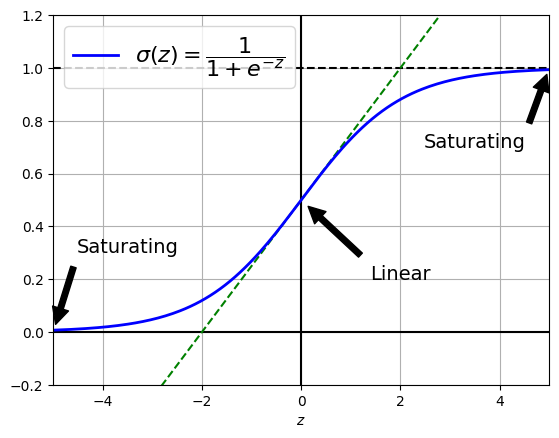

In [ ]:
# Plotting the sigmoid function and gradients
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

plt.show()

The sigmoid function saturates at 0 or 1, with a derivative extremely close to 0 (i.e., the curve is flat at both extremes). If the values have increased through the process above (initialization+sigmoid), when backpropagation kicks in it has virtually no gradient to propagate back through the network.

It took over a decade for researchers to realize how important initialization is. To be able to train NNs with back-propagation, we need to make sure the signal does not die out, nor explode and saturate.


---


**Task 1:**
Do a quick research about the Xavier/Glorot initialization technique on the web (you can also try genAI tools) and answer the questions below:

*   How are weights initialized in this technique
*   What is the goal?
*   Where does it work best?
*   What are the limitations?

**Answer 1:**

Xavier/Glorot initialization sets neural network weights based on the number of neurons in the layer to keep the scale of gradients roughly the same in all layers. For uniform distribution, it draws weights within a range defined by the number of input and output connections. The goal is to prevent vanishing/exploding gradients to ensure efficient training of deep networks. It's most effective with symmetric activation functions like tanh but has limitations with non-zero-centered activations like ReLU, where He initialization may be preferable .

## Xavier/Glorot and He Initialization

Here is how you can use Xavier/Glorot and He Initialization in Keras

In [ ]:
# Relu and He initialization
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [ ]:
# Sigmoid and He initialization
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

Our textbook recommends the following initialization methods based on the activation functions used:

![Initialization](https://user-images.githubusercontent.com/48206667/120094668-66661a80-c13f-11eb-8398-8c381f56e182.png)

We have shortly considered the role of initialization. It is time to also consider the role of activation functions since they are central to controlling the flow of gradients during the training of deep neural networks.


---

**Task 2:** Shortly explain the role of activation function in the vanishing/exploding gradients problem.


**Answer 2:**

Activation functions influence the gradient's magnitude during backpropagation. Functions like sigmoid or tanh can lead to vanishing gradients as their outputs saturate, causing gradients to become very small and slowing down learning. Conversely, improper initialization with these functions can cause gradients to explode, destabilizing the learning process. ReLU and its variants are less prone to vanishing gradients for positive inputs but require careful use to prevent other issues like dead neurons.

## Nonsaturating Activation Functions

Some alternative activation functions are demonstrated below. Examine and run code and consider how gradients vary in different parts of the function.

### Leaky ReLU

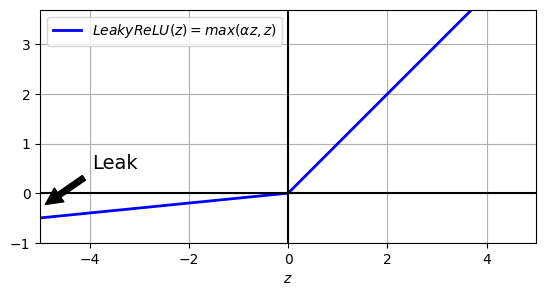

In [ ]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

plt.show()

Here is how you can use Leaky-ReLu in Keras

In [ ]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)  # defaults to alpha=0.3
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [ ]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [ ]:
dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

### SELU

Using SELU is straightforward:

In [ ]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

**An example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

4422102/4422102 [==============================] - 0s 0us/step


**Task 3:** Below cell creates a neural net with **25 hidden layers each having 20 neurons**, using the SELU activation function ( check-out the for loop adding hidden layers). Starting from that starter code, carry the following experiment:



1.  Write code that uses all combinations of:
*   activation functions: 'sigmoid','relu','elu','selu' and
*   initialization methods 'lecun_normal' and 'he_normal' and
*   using batch-norm or not,

Use cross-entropy loss and SGD optimizer with a learning rate of 0.001. Set accuracy as the metric.

2.  Run training (model.fit()) for 5 epochs and report the validation accuracy for each combination
3.  Report your findings

**!!! This experiment will take quite long to finish, so once you implement and run it, continue with the following notebook and come back**

[Notebook 2](https://colab.research.google.com/drive/1aRSbch2xBx8x4RRlNCdO7uQONHDJ5_zr?usp=sharing)

In [ ]:
num_layers = 50
num_neurons = 100
activation_func = 'selu'
initializer = "lecun_normal"

tf.random.set_seed(42)
model = tf.keras.Sequential()
# Input Layer
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
# Hidden layers
for layer in range(num_layers):
  if activation_func == 'leaky_relu':
    model.add(tf.keras.layers.Dense(num_neurons, kernel_initializer=initializer)),  # no activation
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2)),  # activation as a separate layer
  else:
    model.add(tf.keras.layers.Dense(100, activation=activation_func,
                                    kernel_initializer=initializer))
# Output layer
model.add(tf.keras.layers.Dense(10, activation="softmax"))


While the next experiment continues to run work on [Notebook 2](https://colab.research.google.com/drive/1aRSbch2xBx8x4RRlNCdO7uQONHDJ5_zr?usp=sharing)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy


activation_functions = ['sigmoid', 'relu', 'elu', 'selu']
initializers = ['lecun_normal', 'he_normal']
batch_norm = [False, True]

# Record of all experiments
experiments = []

for activation in activation_functions:
    for initializer in initializers:
        for use_bn in batch_norm:
            # Define the model
            model = Sequential()
            model.add(Flatten(input_shape=[28, 28]))
            for _ in range(25):  # 25 hidden layers, each with 20 neurons
                if use_bn:
                    model.add(BatchNormalization())
                model.add(Dense(20, kernel_initializer=initializer))
                if activation == 'leaky_relu':
                    model.add(LeakyReLU(alpha=0.2))
                else:
                    model.add(Dense(20, activation=activation))
            model.add(Dense(10, activation='softmax'))  # Output layer

            # Compile the model
            model.compile(
                optimizer=SGD(learning_rate=0.001),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
            )

            # Fit the model
            history = model.fit(
                X_train, y_train,
                epochs=5,
                validation_data=(X_valid, y_valid)
            )

            # Store the results
            experiments.append({
                'activation': activation,
                'initializer': initializer,
                'batch_norm': use_bn,
                'val_accuracy': history.history['val_accuracy'][-1]
            })

# Sort the results by validation accuracy
experiments.sort(key=lambda x: x['val_accuracy'], reverse=True)

# Display the results
for experiment in experiments:
    print(f"Activation: {experiment['activation']}, Initializer: {experiment['initializer']}, "
          f"Batch Norm: {'Yes' if experiment['batch_norm'] else 'No'}, "
          f"Validation Accuracy: {experiment['val_accuracy']}")


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1719/1719 [==============================] - 18s 8ms/step - loss: 2.3554 - accuracy: 0.0996 - val_loss: 2.3151 - val_accuracy: 0.0994
Epoch 2/5
1719/1719 [==============================] - 12s 7ms/step - loss: 2.3098 - accuracy: 0.0992 - val_loss: 2.3036 - val_accuracy: 0.1016
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 2.3037 - accuracy: 0.0991 - val_loss: 2.3025 - val_accuracy: 0.1016
Epoch 4/5
1719/1719 [==============================] - 11s 7ms/step - loss: 2.3028 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1016
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 2.3027 - accuracy: 0.0990 - val_loss: 2.3027 - val_accuracy: 0.0934
Epoch 1/5
1719/1719 [==============================] - 35s 14ms/step - loss: 2.0811 - accuracy: 0.3039 - val_loss: 1.7985 - val_accuracy: 0.4634
Epoch 2/5
1719/1719 [==============================] - 24s 14ms/step - loss: 1.7250 - accuracy: 0.4983 - val_loss: 1.5326 - val_accuracy: 0.5934


**Task 4:** Summarize the experiment in [Notebook 2](https://colab.research.google.com/drive/1aRSbch2xBx8x4RRlNCdO7uQONHDJ5_zr?usp=sharing) (on transfer learning). What was aimed at? What was your observation?

**Answer 4:** The aim of the transfer learning experiment in Notebook 2 was to investigate whether a model trained on one task (Task A: classifying 8 classes of fashion items except T-shirts/tops and pullovers) could improve its performance on a related but different task (Task B: binary classification of just T-shirts/tops and pullovers) by reusing the knowledge from the first task.

The experiment showed that by reusing the layers from the model trained on Task A and fine-tuning them on the much smaller dataset of Task B, the model could leverage the learned features and perform better than a model trained from scratch on Task B alone. This suggests that transfer learning is a powerful technique, especially when labeled data for the new task is limited.